In [12]:
import tensorflow as tf
import numpy as np

In [13]:
import pickle
with open('cropdata', 'rb') as f:
    data = pickle.load(f)
for key in data:
    print(key)

sad
neutral
happy


In [14]:
print(data['happy'].shape)
input_size = data['happy'].shape[1]

(400, 7000)


[[-778.84430304 -357.98196446 -525.94459399]
 [-709.68781545 -301.89768977 -220.30546285]
 [-254.29138656  -95.02404481 -674.10330217]
 ..., 
 [ 679.96395143  714.56942739  -65.88682638]
 [ 223.10181029 -349.92344017  479.6914459 ]
 [ 387.72298197   25.52110171 -375.24861397]]


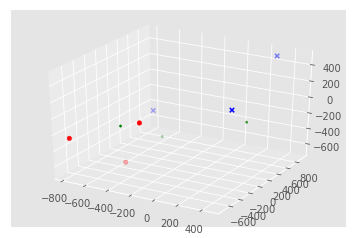

In [15]:
from sklearn import decomposition
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy
plt.style.use("ggplot")

pca = decomposition.PCA(n_components=3)
pca.fit(data['happy'])
x = pca.transform(data['happy'])
#x = numpy.array(x).transpose()

pca = decomposition.PCA(n_components=3)
pca.fit(data['sad'])
y = pca.transform(data['sad'])
#y = numpy.array(y).transpose()

pca.fit(data['neutral'])
z = pca.transform(data['neutral'])
#z = numpy.array(z).transpose()
numpy.savetxt("fo_x.csv", x, delimiter=",")
numpy.savetxt("fo_y.csv", y, delimiter=",")
numpy.savetxt("fo_z.csv", z, delimiter=",")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
print(x)
ax.scatter(x[0], x[1], x[2], c='r', marker='o')
ax.scatter(y[0], y[1], y[2], c='b', marker='x')
ax.scatter(z[0], z[1], z[2], c='g', marker='.')
plt.show()

In [5]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

x2, y2, z2 = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=12,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

Aw, snap! We don't have an account for ''. Want to try again? You can authenticate with your email address or username. Sign in is not case sensitive.

Don't have an account? plot.ly

Questions? support@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

encoding_dim = 1800

input_img = Input(shape=(input_size,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(input_size)(encoded)

autoencoder = Model(input_img, decoded)

In [ ]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')#from keras.datasets import mnist

In [ ]:
x = data['neutral']
y = data['happy']

x_train = x[:350]
X_train = y[:350]
autoencoder.fit(x_train, X_train,
                epochs=30,
                batch_size=32,
                shuffle=True,
                validation_data=(x[350:375], y[350:375])
               )# encode and decode some digits
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test)
# decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
# lol

In [ ]:
import librosa
# import numpy as np
from IPython.lib.display import Audio

def invlogamplitude(S):
    """librosa.logamplitude is actually 10_log10, so invert that."""
    return 10.0**(S/10.0)

# filename = "a.wav"
# y, sr = librosa.load(filename)

# Y = librosa.stft(y)
# mfccs = librosa.feature.mfcc(y, n_mfcc=100)
def recon(mfccs):
    sr = 22050

    n_mfcc = mfccs.shape[0]
    n_mel = 128
    dctm = librosa.filters.dct(n_mfcc, n_mel)
    n_fft = 2048
    mel_basis = librosa.filters.mel(sr, n_fft)

    bin_scaling = 1.0/np.maximum(0.0005, np.sum(np.dot(mel_basis.T, mel_basis),
    axis=0))

    recon_stft = bin_scaling[:, np.newaxis] * np.dot(mel_basis.T,
    invlogamplitude(np.dot(dctm.T, mfccs)))

    excitation = np.random.randn(mfccs.shape[1] * 510)
    E = librosa.stft(excitation)
    recon = librosa.istft(E/np.abs(E)*np.sqrt(recon_stft))

    print(mfccs.shape)
    return Audio(recon, rate=sr)


In [ ]:
xy = x[386].reshape((1, input_size))
# print(x[380].shape)
# print(xy.shape)
encoded_imgs = encoder.predict(xy)
mfccs = decoder.predict(encoded_imgs)

mfccs = autoencoder.predict(xy)

# mfccs = mfccs.reshape((200, 25800//200))
print(mfccs)
# print(divy)
print(np.min(data['happy']))
print(mfccs.shape)

In [ ]:
mxx = xy.reshape((200, input_size // 200), order='F')
# mxx = mxx * divx
# mxx += np.min(data['neutral'])

recon(mxx)
# recon(mfccs)

In [ ]:
myy = mfccs.reshape((200, input_size // 200), order='F')
# myy = myy * divy
# myy += np.min(data['happy'])

recon(myy)

In [ ]:
model_json= autoencoder.to_json()
with open("autoencoder.json","w") as json_file:
    json_file.write(model_json)
    
autoencoder.save_weights("autoencoder.h5")